# Stacked GRU Cells for Classification of Quantum Measurements

In [1]:
%matplotlib inline
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.signal import hilbert

In [2]:
hdf = h5py.File(r"datasets/easy_example_data_very_short.h5", "r")
data = np.array(hdf['data_tensor'])
print(data.shape)
[np.mean(data), np.var(data), np.std(data)]

(200000, 2, 100)


[-0.0028786126, 0.003016161, 0.054919586]

In [3]:
d_transform = data
d_transform.shape

(200000, 2, 100)

## Visualisation of the Traces V(t)

0 99
0.0 1.0


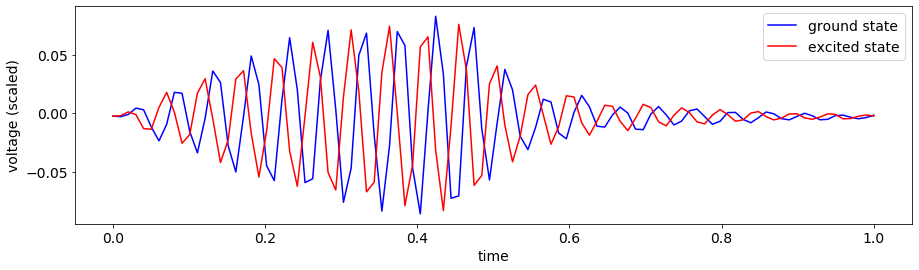

(2, 100)

In [4]:
d_av = np.mean(d_transform, axis=0)
t = np.array(range(len(d_transform[0, 0])))
print(t[0], t[-1])
xf = np.arange(len(t))*1./t[-1]
print(xf[0], xf[-1])
# plot average signals
plt.figure(figsize=(15,4))
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.xlabel("time", fontsize=14)
plt.ylabel("voltage (scaled)", fontsize=14)
plt.plot(xf, d_av[0], "b-", label="ground state")
plt.plot(xf, d_av[1], "r-", label="excited state")
plt.legend(loc="best", fontsize=14)
plt.show()
d_av.shape

## Demodulation (for a given set of parameters)


In [5]:
d = d_transform
#Construction of the demodulation weight function w(t) = x + iy 
x = (d_av[1]-d_av[0])/2.
y = np.real(np.fft.irfft(np.fft.rfft(x, axis = -1)*1j,x.shape[0], axis = -1)) 
#Normalazing : actual axis not calibrated for this experiment
x = x/np.sqrt(np.sum(x**2))
y = y/np.sqrt(np.sum(y**2))
#Demodulation
dIQ = d*(x+1j*y)
dint = np.average(dIQ,axis = -1)
dint = dint.T
dint.shape

(2, 200000)

In [6]:
# Histogram functions
a = np.amax(np.abs(dint)) #fixing the range
r = [[-a,a],[-a,a]]
def hist(dint,ge):
    h = np.histogram2d(np.real(dint[ge]),np.imag(dint[ge]), bins = 50, normed = False, range = r)[0]
    return h    
def ol(dint): # 2d scalar product
    Pg = hist(dint,0)
    Pe = hist(dint,1)
    o = np.sum(Pg*Pe)/(np.sqrt(np.sum(Pg**2))*np.sqrt(np.sum(Pe**2)))
    return o
print('Overlap : '+str(ol(dint)*100) +'%')
def Z(data,ge): #Defining the zone associated with either g or e
    z = hist(data,ge) >  hist(data,1-ge)
    z = z + (hist(data,ge) ==  hist(data,1-ge))*0.5
    return z
def ol_z(data,ge): #Computation of the error
    o = np.sum(Z(data,ge)*hist(data,ge))/np.sum(hist(data,ge))
    return o
print('Error by zone, g: '+str((1-ol_z(dint,0))*100) +'%, e: '+str((1-ol_z(dint,1))*100) +'%')
fidelity = ((ol_z(dint,0)) + (ol_z(dint,1)))/2 * 100
print("Fidelity: " + str(fidelity) + "%" )

Overlap : 4.178038070467027%
Error by zone, g: 1.2042499999999956%, e: 3.006249999999999%
Fidelity: 97.89475%


(51,)


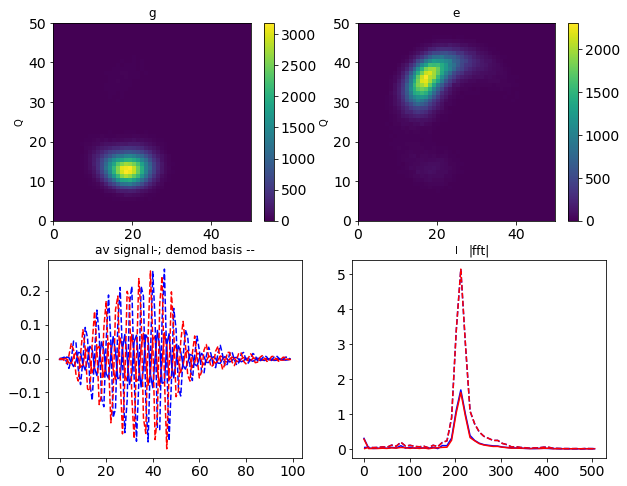

In [7]:
# make plot with 4 subplots
fig, ax = plt.subplots(2,2, figsize=(10,8))
# subplot 1
plot = ax[0,0].pcolormesh(hist(dint,0)) # histogram for ground state
fig.colorbar(plot,ax=ax[0,0],orientation='vertical')
ax[0,0].set_xlabel('I') # Re[\beta], see Eq. (2)
ax[0,0].set_ylabel('Q') # Im[\beta], see Eq. (2)
ax[0,0].set_title('g')  # ground state label
ax[0,0].axis('tight')   # save space
ax[0,0].set_aspect(1)   # aspect ratio
# subplot 2
plot = ax[0,1].pcolormesh(hist(dint,1)) # histogram for excited state; as above
fig.colorbar(plot,ax=ax[0,1],orientation='vertical')
ax[0,1].set_xlabel('I')
ax[0,1].set_ylabel('Q')
ax[0,1].set_title('e')
ax[0,1].axis('tight')
ax[0,1].set_aspect(1)
# subplot 3
ax[1,0].plot(t, d_av[0], 'b-')        # plot V(t), averaged over all ground states (in blue, solid)
ax[1,0].plot(t, d_av[1], 'r-')        # plot V(t), averaged over all excited states (in red, solid)
ax[1,0].plot(t, x, 'b--')             # real part of wavelet w(t) in Eq. (2); defined as the difference of average ...
ax[1,0].plot(t, y, 'r--')             # ... V_e(t) and average V_g(t), see definition above; imaginary part of w(t)
ax[1,0].set_title('av signal -; demod basis --')
# prepare x-axis for subplot 4
xf = np.arange(len(t)/2+1)*1000./t[-1]                 # Why all this?
print(xf.shape)
# subplot 4
ax[1,1].plot(xf, np.abs(np.fft.rfft(d_av[0])), 'b-') # Fourier ...
ax[1,1].plot(xf, np.abs(np.fft.rfft(d_av[1])), 'r-') # ... transforms ...
ax[1,1].plot(xf, np.abs(np.fft.rfft(x)), 'b--')      # ... of plots ...
ax[1,1].plot(xf, np.abs(np.fft.rfft(y)), 'r--')      # ... in subplot 3 ...
ax[1,1].set_title('|fft|')                           # ... with same lines
# show all subplots
plt.show()

## Dataset Preparation

In [8]:
d_g = d_transform[:, 0, :]                           # ground state features
class_g = np.array([[0 for i in range(len(d_g))]]).T # ground state labels
d_g = np.concatenate((class_g, d_g), axis=1)         # ground state features, labels
print(d_g.shape)
d_g[0:3, 0:2]

(200000, 101)


array([[ 0.        , -0.02432234],
       [ 0.        , -0.00556777],
       [ 0.        ,  0.01084249]])

In [9]:
d_g = d_transform[:, 0, :]                           # ground state features
class_g = np.array([[0 for i in range(len(d_g))]]).T # ground state labels
d_g = np.concatenate((class_g, d_g), axis=1)         # ground state features, labels
d_e = d_transform[:, 1, :]                           # excited state features
class_e = np.array([[1 for i in range(len(d_e))]]).T # excited state labels
d_e = np.concatenate((class_e, d_e), axis=1)         # excited state features, labels
ge_data = np.concatenate((d_g, d_e), axis=0)         # ground and excited state labels, features
print(ge_data.shape)                                 # instances, label + features
# for np.random.seed, see https://stackoverflow.com/questions/21494489/what-does-numpy-random-seed0-do/21494630
np.random.seed(0)
shuffle_index = np.random.permutation(len(ge_data))  # create a random order (via indices)
print(shuffle_index[:5])                             # show a few randomized indices
first_5_pseudo_random = np.array([242160, 3413, 393024, 247987, 52436])
print(np.linalg.norm(first_5_pseudo_random - shuffle_index[:5]) == 0)
ge_shuffle_data = ge_data[shuffle_index]             # apply the random order
X_data = ge_shuffle_data[:, 1:]                      # select the features ...
Y_data = ge_shuffle_data[:, :1]                      # ... and the labels
print(X_data.shape)    # shape of feature data
print(Y_data.shape)    # shape of label data
print(X_data[:10, :5]) # for the first 10 instances, show the first 5 features, ...
Y_data[:10]            # ... and the according label

(400000, 101)
[242160   3413 393024 247987  52436]
True
(400000, 100)
(400000, 1)
[[-0.04483517 -0.12669109 -0.02197802 -0.01279609 -0.05401709]
 [-0.01826618 -0.03936508 -0.01787546 -0.04815629 -0.03135531]
 [-0.01357753  0.01142857 -0.02627595 -0.04952381 -0.07042735]
 [ 0.00283272  0.03506716 -0.04190476 -0.02608059 -0.04092796]
 [-0.02002442  0.00107448 -0.03760684  0.00126984  0.04971917]
 [-0.00205128 -0.03799756 -0.07101343 -0.02021978  0.01260073]
 [-0.00849817  0.05128205  0.04034188 -0.00380952  0.05264957]
 [ 0.01846154  0.02393162  0.03565324  0.03194139  0.03213675]
 [-0.08253969 -0.06964591  0.00967033  0.10813187  0.07531136]
 [-0.04620269  0.02725275  0.01279609 -0.02002442 -0.02588523]]


array([[1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [10]:
print(len(Y_data))
split1 = int(0.8 * len(Y_data))
split2 = int(0.8 * split1)
# use test data for evaluation of the final (!) model (after development)
X_test, Y_test = X_data[split1:], Y_data[split1:]
print(X_test.shape, Y_test.shape)
# use validation data for early stopping and evaluation of different models (during development)
X_valid, Y_valid = X_data[split2:split1], Y_data[split2:split1]
print(X_valid.shape, Y_valid.shape)
# use training data for training / fitting different models (during development)
X_train, Y_train = X_data[:split2], Y_data[:split2]
print(X_train.shape, Y_train.shape)
# scaling all data by training set
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)
print(X_train_mean, X_train_std)
X_train = (X_train - X_train_mean) / X_train_std
X_valid = (X_valid - X_train_mean) / X_train_std
X_test  = (X_test  - X_train_mean) / X_train_std

400000
(80000, 100) (80000, 1)
(64000, 100) (64000, 1)
(256000, 100) (256000, 1)
-0.0028821402231842103 0.054921891350041704


## TensorFlow RNN

In [11]:
import tensorflow as tf
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
n_steps = 20
n_inputs = 5
x_valid = X_valid.reshape(-1, n_steps, n_inputs)
y_valid = Y_valid[:, 0]
x_test = X_test.reshape(-1, n_steps, n_inputs)
y_test = Y_test[:, 0]
def next_batch(batch_size):
    shuffle_idx = np.random.permutation(split2)[:batch_size]
    x_batch = X_train[shuffle_idx].reshape(-1, n_steps, n_inputs)
    y_batch = Y_train[shuffle_idx, 0]
    return x_batch, y_batch
next_batch(3)

/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:496: FutureWarning: Passing (type, 1) or 

(array([[[-0.65715544,  0.27123596,  0.43130343, -0.76386708,
          -1.34722406],
         [-0.36547691, -0.24453704, -0.69272598, -0.048899  ,
           0.93996233],
         [-0.43306096, -2.50326705,  0.21076602,  1.74385677,
          -0.1520536 ],
         [-1.01641801, -1.78829898,  0.42418933,  0.60915621,
           0.66962613],
         [-0.04178489, -0.89192109,  1.45929238,  2.28452917,
           0.21788014],
         [-2.3574279 , -0.8954781 ,  2.05687768,  2.60466425,
           0.80479423],
         [-1.74561427, -1.00218975,  1.72962858,  1.32768129,
          -0.79232354],
         [-1.71004372, -0.72118244,  1.28855379,  1.24586908,
          -0.88124991],
         [-1.04131738,  0.95774761,  2.20983099,  0.58425681,
          -2.48192482],
         [-1.99105103,  1.31701018,  2.82520144,  0.08271204,
          -0.77453826],
         [-0.09514071,  1.14982861,  1.11425806, -0.62158489,
           0.16808137],
         [ 0.98976107,  0.44553166, -0.53621553, -1.34

In [13]:
### construction
# architecture
reset_graph()
n_neurons = 150
n_outputs = 2
n_layers = 3                                                                # number of layers in multi_layer_cell
# training details
LR = 0.01              # learning rate
n_early_stopping = 250 # stop after this number of epochs without improvement on validation set
acc_valid_max = 0      # initial value of accuracy maximum
n_epochs = 2#10000       # number of epochs
batch_size = 256       # batch size
l2_scale = 0.002       # l2 regularization
# network
x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])                   # input instances
y = tf.placeholder(tf.int32, [None])                                        # input classes
lr = tf.placeholder(tf.float32)                                             # learning rate
layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons)                       # build layers and put ...
          for layer in range(n_layers)]                                     # ... them into "layers"
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers, state_is_tuple=True) # MultiRNNCell
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, x, dtype=tf.float32)  # use dynamic_rnn to automatically ...
                                                                            # ... feed output as the next input
logits = tf.layers.dense(states[-1], n_outputs)                             # last step (automatic), highest layer
# cost function and training
regularize_these = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,      # use ".*kernel.*|.*diag.*" ... 
                                     scope=".*kernel.*|.*diag.*")           # ... (or just ".*kernel.*")
[print(i) for i in regularize_these]                                        # all these shall be regularized
print()
l2_loss = l2_scale * sum([tf.reduce_sum(tf.square(i)) for i in regularize_these])
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits) # cross entropy
loss = l2_loss + tf.reduce_mean(xentropy)                                         # loss = average xentropy over batch
optimizer = tf.train.AdamOptimizer(learning_rate=lr)                              # adam optimizer
training_op = optimizer.minimize(loss)                                            # minimize the loss
# classification and accuracy
correct = tf.nn.in_top_k(logits, y, 1)                                            # yes or no (1 or 0)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))                           # accuracy = avg of correct (1 or 0)
# initializer and saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()
### execution
with tf.Session() as sess:                                                        # start session
    init.run()                                                                    # initialize variables
    for epoch in range(n_epochs):                                                 # loop over epochs
        acc_train = 0
        count = 0
        for iteration in range(split2 // batch_size):                             # loop over iterations (batches)
            x_batch, y_batch = next_batch(batch_size)
            sess.run(training_op, feed_dict={x: x_batch, y: y_batch, lr: LR})     # feed batch to training operation
            acc_train += accuracy.eval(feed_dict={x: x_batch, y: y_batch})
            count += 1
            print("\rEpoch: {:d}/{:d}\tIteration: {:d}/{:d}\tTraining accuracy: {:.4f}".format(
                epoch+1, n_epochs, iteration+1, split2//batch_size, acc_train/count), end="")
        acc_valid = accuracy.eval(feed_dict={x: x_valid , y: y_valid})            # get accuracy on validation set
        print("\tValidation accuracy: {:.4f}".format(acc_valid))                  # print accuracy on validation set
        # learning schedule and early stopping
        if acc_valid > acc_valid_max:
            acc_valid_count = 0
            acc_valid_max = acc_valid
            saver.save(sess, "./RNN_logs/GRU_3/GRU_3")
        else:
            acc_valid_count += 1
        if acc_valid_count >= n_early_stopping/2:
            LR /= 4
            print("\nLearning rate: {}".format(LR))
        if acc_valid_count == n_early_stopping:
            print("Early stopping")
            break
    saver.restore(sess, "./RNN_logs/GRU_3/GRU_3")
    print("Restoring the best model before computing the accuracy on the test set.")
    acc_test = accuracy.eval(feed_dict={x: x_test , y: y_test})                   # get accuracy on test set
    print("\nTest accuracy: {:.4f}".format(acc_test))                             # print accuracy on test set

<tf.Variable 'rnn/multi_rnn_cell/cell_0/gru_cell/gates/kernel:0' shape=(155, 300) dtype=float32_ref>
<tf.Variable 'rnn/multi_rnn_cell/cell_0/gru_cell/candidate/kernel:0' shape=(155, 150) dtype=float32_ref>
<tf.Variable 'rnn/multi_rnn_cell/cell_1/gru_cell/gates/kernel:0' shape=(300, 300) dtype=float32_ref>
<tf.Variable 'rnn/multi_rnn_cell/cell_1/gru_cell/candidate/kernel:0' shape=(300, 150) dtype=float32_ref>
<tf.Variable 'rnn/multi_rnn_cell/cell_2/gru_cell/gates/kernel:0' shape=(300, 300) dtype=float32_ref>
<tf.Variable 'rnn/multi_rnn_cell/cell_2/gru_cell/candidate/kernel:0' shape=(300, 150) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(150, 2) dtype=float32_ref>

Epoch: 1/2	Iteration: 1000/1000	Training accuracy: 0.9741	Validation accuracy: 0.9762
Epoch: 2/2	Iteration: 1000/1000	Training accuracy: 0.9771	Validation accuracy: 0.9731
INFO:tensorflow:Restoring parameters from ./RNN_logs/GRU_3/GRU_3
Restoring the best model before computing the accuracy on the test set.

Test ac